In [3]:
# Instalar librerías necesarias
%pip install pandas pyreadstat matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Análisis Exploratorio de Datos - Defunciones Guatemala (2009-2020)
## Inciso a: Descripción del Conjunto de Datos

Este notebook analiza los datos de defunciones en Guatemala de 2009 a 2020, describiendo:
- Número de variables y observaciones
- Tipo de cada variable
- Estructura general del dataset unificado

## 1. Importar Librerías Necesarias

In [4]:
import pandas as pd
import numpy as np
import pyreadstat
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


## 2. Cargar y Explorar Archivos .sav Individuales

Primero, identificamos todos los archivos .sav disponibles y exploramos su estructura.

In [7]:
# Definir la ruta a los datos (subir un nivel desde la carpeta actual)
data_path = Path(r'../data/defunciones/sav')

# Listar todos los archivos .sav
archivos_sav = sorted(list(data_path.glob('*.sav')))

print(f"Total de archivos .sav encontrados: {len(archivos_sav)}\n")
print("Archivos disponibles:")
for i, archivo in enumerate(archivos_sav, 1):
    print(f"{i}. {archivo.name}")

Total de archivos .sav encontrados: 12

Archivos disponibles:
1. 2009-defunciones.sav
2. 2010-defunciones.sav
3. 2011-defunciones.sav
4. 2012-defunciones.sav
5. 2013-defunciones.sav
6. 2014-defunciones.sav
7. 2015-defunciones.sav
8. 2016-defunciones.sav
9. 2017-defunciones.sav
10. 2018-defunciones.sav
11. 2019-defunciones.sav
12. 2020-defunciones.sav


In [8]:
# Explorar un archivo de ejemplo para entender la estructura
ejemplo_archivo = archivos_sav[0]
print(f"Cargando archivo de ejemplo: {ejemplo_archivo.name}\n")

# Cargar el archivo .sav con metadatos
df_ejemplo, meta = pyreadstat.read_sav(str(ejemplo_archivo))

print(f"Dimensiones: {df_ejemplo.shape[0]} observaciones x {df_ejemplo.shape[1]} variables")
print(f"\nPrimeras 5 filas:")
display(df_ejemplo.head())

print(f"\nInformación del DataFrame:")
display(df_ejemplo.info())

Cargando archivo de ejemplo: 2009-defunciones.sav

Dimensiones: 81726 observaciones x 28 variables

Primeras 5 filas:


,Depreg,Mupreg,Mesreg,Añoreg,Depocu,Mupocu,Areag,Sexo,Diaocu,Mesocu,...,Dnadif,Mnadif,Nacdif,Predif,Dredif,Mredif,Caudef,Asist,Ocur,Cerdef
0,1.0,0101,3.0,2017.0,1.0,0101,1.0,2.0,19.0,3.0,...,1.0,0101,320.0,320.0,1.0,0101,A010,1.0,4.0,1.0
1,8.0,0801,1.0,2017.0,8.0,0801,2.0,1.0,23.0,1.0,...,8.0,0801,320.0,320.0,8.0,0801,A010,5.0,6.0,9.0
2,4.0,0401,11.0,2017.0,4.0,0401,1.0,1.0,4.0,11.0,...,4.0,0405,320.0,9999.0,99.0,9999,A010,1.0,1.0,1.0
3,8.0,0801,5.0,2017.0,8.0,0801,2.0,1.0,23.0,5.0,...,14.0,1409,320.0,320.0,8.0,0801,A010,5.0,6.0,9.0
4,6.0,0601,7.0,2017.0,6.0,0601,1.0,2.0,7.0,7.0,...,6.0,0606,320.0,9999.0,99.0,9999,A010,1.0,1.0,1.0



Información del DataFrame:
<class 'pandas.DataFrame'>
RangeIndex: 81726 entries, 0 to 81725
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Depreg   81726 non-null  float64
 1   Mupreg   81726 non-null  str    
 2   Mesreg   81726 non-null  float64
 3   Añoreg   81726 non-null  float64
 4   Depocu   81726 non-null  float64
 5   Mupocu   81726 non-null  str    
 6   Areag    81726 non-null  float64
 7   Sexo     81726 non-null  float64
 8   Diaocu   81726 non-null  float64
 9   Mesocu   81726 non-null  float64
 10  Añoocu   81726 non-null  float64
 11  Edadif   81726 non-null  float64
 12  Perdif   81726 non-null  float64
 13  Puedif   81726 non-null  float64
 14  Ecidif   81726 non-null  float64
 15  Escodif  81726 non-null  float64
 16  Ciuodif  81726 non-null  str    
 17  Pnadif   81726 non-null  float64
 18  Dnadif   81726 non-null  float64
 19  Mnadif   81726 non-null  str    
 20  Nacdif   81726 non-null  float64


None

## 3. Analizar Consistencia de Variables entre Años

Verificamos si las variables son consistentes entre todos los años o si hay cambios.

In [10]:
# Cargar todos los archivos y revisar estructura
estructura_por_anio = {}

for archivo in archivos_sav:
    year = archivo.stem.split('-')[0]  # Extrae el año del nombre del archivo
    df_temp, meta_temp = pyreadstat.read_sav(str(archivo))
    
    estructura_por_anio[year] = {
        'num_obs': df_temp.shape[0],
        'num_vars': df_temp.shape[1],
        'columnas': list(df_temp.columns),
        'tipos': df_temp.dtypes.to_dict()
    }

# Crear DataFrame de resumen
resumen_estructura = pd.DataFrame({
    'Año': list(estructura_por_anio.keys()),
    'Observaciones': [estructura_por_anio[y]['num_obs'] for y in estructura_por_anio.keys()],
    'Variables': [estructura_por_anio[y]['num_vars'] for y in estructura_por_anio.keys()]
})

print("Resumen de estructura por año:")
display(resumen_estructura)

# Verificar consistencia de columnas
todas_columnas = [set(estructura_por_anio[y]['columnas']) for y in estructura_por_anio.keys()]
columnas_comunes = set.intersection(*todas_columnas)
columnas_todas = set.union(*todas_columnas)

print(f"\nTotal de columnas únicas en todos los archivos: {len(columnas_todas)}")
print(f"Columnas comunes a todos los años: {len(columnas_comunes)}")
print(f"Columnas que varían entre años: {len(columnas_todas - columnas_comunes)}")

if columnas_todas != columnas_comunes:
    print("\n Las columnas NO son idénticas en todos los años. Habrá que manejar diferencias al unificar.")

Resumen de estructura por año:


,Año,Observaciones,Variables
0,2009,81726,28
1,2010,72748,26
2,2011,72354,26
3,2012,72657,27
4,2013,76639,28
5,2014,77807,27
6,2015,80876,28
7,2016,82565,28
8,2017,81726,28
9,2018,83071,27



Total de columnas únicas en todos los archivos: 35
Columnas comunes a todos los años: 19
Columnas que varían entre años: 16

 Las columnas NO son idénticas en todos los años. Habrá que manejar diferencias al unificar.


## 4. Unificar Datos de Todos los Años

Como necesitamos trabajar con más de 10 años de datos (según las instrucciones), procedemos a unificar todos los archivos en un solo DataFrame.

In [12]:
# Unificar todos los archivos
dataframes = []
metadatos = {}

for archivo in archivos_sav:
    year = archivo.stem.split('-')[0]
    print(f"Cargando: {archivo.name}...")
    
    df_temp, meta_temp = pyreadstat.read_sav(str(archivo))
    
    # Agregar columna de año
    df_temp['ANIO'] = int(year)
    
    dataframes.append(df_temp)
    metadatos[year] = meta_temp

# Concatenar todos los DataFrames
df_unificado = pd.concat(dataframes, axis=0, ignore_index=True, sort=False)

print(f"\n Datos unificados exitosamente!")
print(f"Total de observaciones: {df_unificado.shape[0]:,}")
print(f"Total de variables: {df_unificado.shape[1]:,}")
print(f"Años incluidos: {sorted(df_unificado['ANIO'].unique())}")

Cargando: 2009-defunciones.sav...
Cargando: 2010-defunciones.sav...
Cargando: 2011-defunciones.sav...
Cargando: 2012-defunciones.sav...
Cargando: 2013-defunciones.sav...
Cargando: 2014-defunciones.sav...
Cargando: 2015-defunciones.sav...
Cargando: 2016-defunciones.sav...
Cargando: 2017-defunciones.sav...
Cargando: 2018-defunciones.sav...
Cargando: 2019-defunciones.sav...
Cargando: 2020-defunciones.sav...

 Datos unificados exitosamente!
Total de observaciones: 963,770
Total de variables: 36
Años incluidos: [np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020)]


## 5. Conteo de Variables y Observaciones

Resumen del conjunto de datos unificado.

In [13]:
# Resumen por año
observaciones_por_anio = df_unificado.groupby('ANIO').size().reset_index(name='Observaciones')
print("Distribución de observaciones por año:")
display(observaciones_por_anio)

# Estadísticas generales
print(f"\n{'='*60}")
print(f"RESUMEN DEL CONJUNTO DE DATOS UNIFICADO")
print(f"{'='*60}")
print(f"Total de observaciones (registros): {df_unificado.shape[0]:,}")
print(f"Total de variables (columnas): {df_unificado.shape[1]:,}")
print(f"Período cubierto: {df_unificado['ANIO'].min()} - {df_unificado['ANIO'].max()}")
print(f"Años de datos: {df_unificado['ANIO'].nunique()} años")
print(f"{'='*60}")

Distribución de observaciones por año:


,ANIO,Observaciones
0,2009,81726
1,2010,72748
2,2011,72354
3,2012,72657
4,2013,76639
5,2014,77807
6,2015,80876
7,2016,82565
8,2017,81726
9,2018,83071



RESUMEN DEL CONJUNTO DE DATOS UNIFICADO
Total de observaciones (registros): 963,770
Total de variables (columnas): 36
Período cubierto: 2009 - 2020
Años de datos: 12 años


## 6. Clasificación de Tipos de Variables

Analizamos cada variable para clasificarla como numérica (continua/discreta) o categórica.

In [14]:
# Clasificar variables
clasificacion_vars = []

for columna in df_unificado.columns:
    dtype = df_unificado[columna].dtype
    num_unicos = df_unificado[columna].nunique()
    valores_ejemplo = df_unificado[columna].dropna().head(3).tolist()
    
    # Clasificar tipo de variable
    if dtype in ['int64', 'float64']:
        if num_unicos <= 20:
            tipo_var = 'Numérica Discreta'
        else:
            tipo_var = 'Numérica Continua'
    else:
        tipo_var = 'Categórica'
    
    clasificacion_vars.append({
        'Variable': columna,
        'Tipo_Dato': str(dtype),
        'Tipo_Variable': tipo_var,
        'Valores_Únicos': num_unicos,
        'Ejemplo_Valores': str(valores_ejemplo[:3])
    })

df_clasificacion = pd.DataFrame(clasificacion_vars)

# Mostrar resumen
print("Resumen de tipos de variables:")
print(df_clasificacion['Tipo_Variable'].value_counts())
print(f"\nTotal de variables: {len(df_clasificacion)}")

# Mostrar tabla completa
print("\nDetalle de todas las variables:")
display(df_clasificacion)

Resumen de tipos de variables:
Tipo_Variable
Numérica Discreta    16
Categórica           11
Numérica Continua     9
Name: count, dtype: int64

Total de variables: 36

Detalle de todas las variables:


,Variable,Tipo_Dato,Tipo_Variable,Valores_Únicos,Ejemplo_Valores
0,Depreg,float64,Numérica Continua,22,"[1.0, 8.0, 4.0]"
1,Mupreg,str,Categórica,340,"['0101', '0801', '0401']"
2,Mesreg,float64,Numérica Discreta,12,"[3.0, 1.0, 11.0]"
3,Añoreg,float64,Numérica Discreta,12,"[2017.0, 2017.0, 2017.0]"
4,Depocu,float64,Numérica Continua,22,"[1.0, 8.0, 4.0]"
5,Mupocu,str,Categórica,340,"['0101', '0801', '0401']"
6,Areag,float64,Numérica Discreta,3,"[1.0, 2.0, 1.0]"
7,Sexo,float64,Numérica Discreta,2,"[2.0, 1.0, 1.0]"
8,Diaocu,float64,Numérica Continua,31,"[19.0, 23.0, 4.0]"
9,Mesocu,float64,Numérica Discreta,12,"[3.0, 1.0, 11.0]"


## 7. Tabla de Resumen Completo con Metadatos

Generamos una tabla comprehensiva con información detallada de cada variable, incluyendo etiquetas de los archivos SPSS.

In [16]:
# Obtener etiquetas de variables desde los metadatos SPSS
meta_ejemplo = metadatos[list(metadatos.keys())[0]]  # Usar metadatos del primer año

resumen_completo = []

for columna in df_unificado.columns:
    # Obtener etiqueta desde metadatos si existe
    etiqueta = meta_ejemplo.column_names_to_labels.get(columna, 'Sin descripción')
    
    # Información básica
    num_missing = df_unificado[columna].isna().sum()
    pct_missing = (num_missing / len(df_unificado)) * 100
    num_unicos = df_unificado[columna].nunique()
    
    # Tipo de variable
    tipo_fila = df_clasificacion[df_clasificacion['Variable'] == columna]['Tipo_Variable'].values
    tipo_var = tipo_fila[0] if len(tipo_fila) > 0 else 'N/A'
    
    resumen_completo.append({
        'Variable': columna,
        'Descripción': etiqueta,
        'Tipo': tipo_var,
        'Tipo_Dato': str(df_unificado[columna].dtype),
        'Valores_Únicos': num_unicos,
        'Valores_Faltantes': num_missing,
        '% Faltantes': f"{pct_missing:.2f}%"
    })

df_resumen = pd.DataFrame(resumen_completo)

print("TABLA RESUMEN COMPLETA DE VARIABLES")
print("="*80)
display(df_resumen)

# Guardar a CSV para referencia
df_resumen.to_csv('resumen_variables_defunciones.csv', index=False, encoding='utf-8-sig')
print("\n Tabla guardada en: resumen_variables_defunciones.csv")

TABLA RESUMEN COMPLETA DE VARIABLES


,Variable,Descripción,Tipo,Tipo_Dato,Valores_Únicos,Valores_Faltantes,% Faltantes
0,Depreg,Departamento de registro,Numérica Continua,float64,22,0,0.00%
1,Mupreg,Municipio de registro,Categórica,str,340,145102,15.06%
2,Mesreg,Mes de registro,Numérica Discreta,float64,12,0,0.00%
3,Añoreg,Año de registro,Numérica Discreta,float64,12,0,0.00%
4,Depocu,Departamento de ocurrencia,Numérica Continua,float64,22,0,0.00%
5,Mupocu,Municipio de ocurrencia,Categórica,str,340,145102,15.06%
6,Areag,Área geográfica de ocurrencia,Numérica Discreta,float64,3,264672,27.46%
7,Sexo,Sexo del difunto(a),Numérica Discreta,float64,2,0,0.00%
8,Diaocu,Día de ocurrencia,Numérica Continua,float64,31,0,0.00%
9,Mesocu,Mes de ocurrencia,Numérica Discreta,float64,12,0,0.00%



 Tabla guardada en: resumen_variables_defunciones.csv


## 8. Visualización de la Distribución de Tipos de Variables

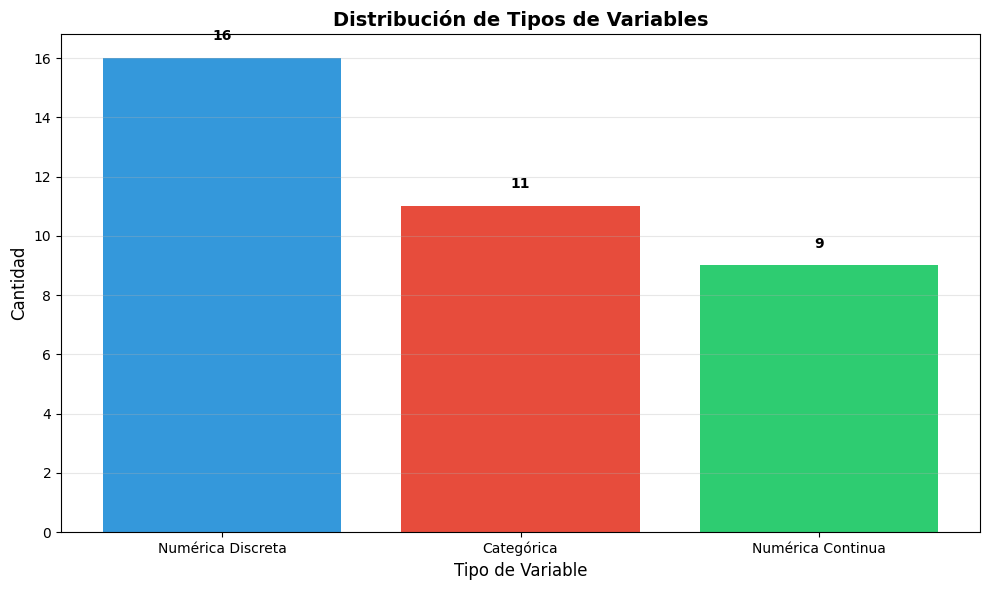


Resumen estadístico:
  Numérica Discreta: 16 variables (44.4%)
  Categórica: 11 variables (30.6%)
  Numérica Continua: 9 variables (25.0%)


In [17]:
import matplotlib.pyplot as plt

# Contar tipos de variables
conteo_tipos = df_resumen['Tipo'].value_counts()

# Crear visualización
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Gráfico de barras
ax.bar(conteo_tipos.index, conteo_tipos.values, color=['#3498db', '#e74c3c', '#2ecc71'])
ax.set_xlabel('Tipo de Variable', fontsize=12)
ax.set_ylabel('Cantidad', fontsize=12)
ax.set_title('Distribución de Tipos de Variables', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(conteo_tipos.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nResumen estadístico:")
for tipo, cantidad in conteo_tipos.items():
    porcentaje = (cantidad / len(df_resumen)) * 100
    print(f"  {tipo}: {cantidad} variables ({porcentaje:.1f}%)")

## 9. Análisis de Valores Faltantes

Identificamos variables con alta proporción de datos faltantes.

Variables con valores faltantes: 16 de 36

Top 10 variables con más valores faltantes:


,Variable,Descripción,Tipo,Tipo_Dato,Valores_Únicos,Valores_Faltantes,% Faltantes
34,mnadif,Sin descripción,Categórica,str,335,891022,92.45%
35,caudef.descrip,Sin descripción,Categórica,str,1452,887131,92.05%
30,mupocu,Sin descripción,Categórica,str,333,818668,84.94%
29,mupreg,Sin descripción,Categórica,str,333,818668,84.94%
31,añoocu,Sin descripción,Numérica Discreta,float64,2,818668,84.94%
33,Ocudif,Sin descripción,Categórica,str,255,746011,77.41%
32,Getdif,Sin descripción,Numérica Discreta,float64,3,746011,77.41%
10,Añoocu,Año de ocurrencia,Numérica Discreta,float64,6,372205,38.62%
6,Areag,Área geográfica de ocurrencia,Numérica Discreta,float64,3,264672,27.46%
16,Ciuodif,Ocupación (Subgrupos CIUO-08) del difunto (a),Categórica,str,46,217759,22.59%


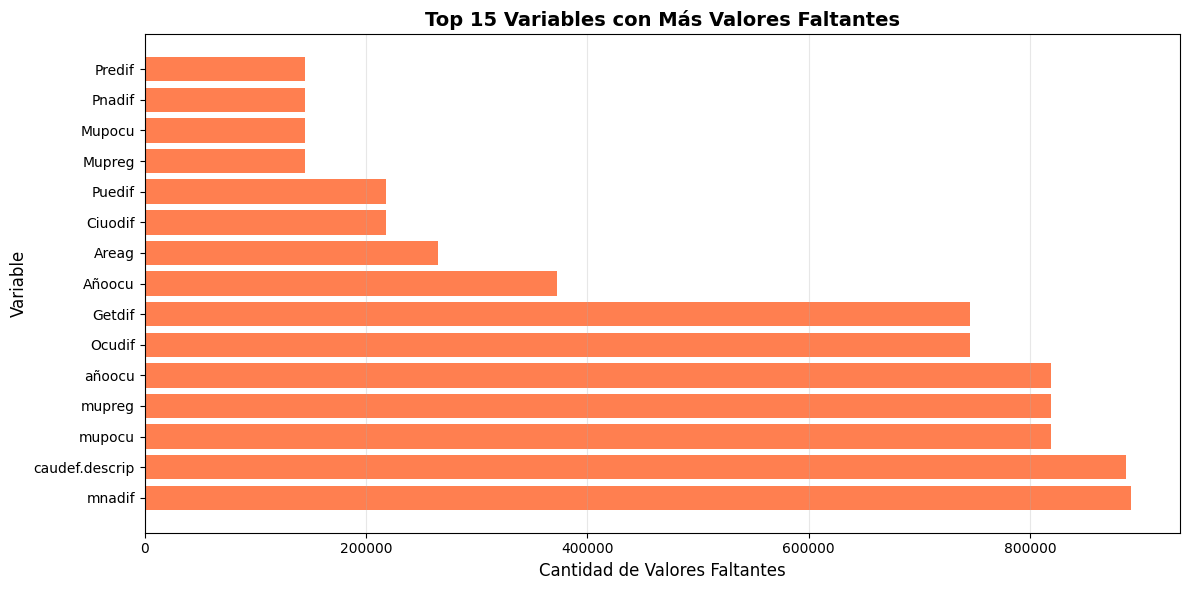

In [18]:
# Variables con valores faltantes
df_missing = df_resumen[df_resumen['Valores_Faltantes'] > 0].sort_values('Valores_Faltantes', ascending=False)

print(f"Variables con valores faltantes: {len(df_missing)} de {len(df_resumen)}")
print(f"\nTop 10 variables con más valores faltantes:")
display(df_missing.head(10))

# Visualizar
if len(df_missing) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    top_missing = df_missing.head(15)
    ax.barh(top_missing['Variable'], top_missing['Valores_Faltantes'], color='coral')
    ax.set_xlabel('Cantidad de Valores Faltantes', fontsize=12)
    ax.set_ylabel('Variable', fontsize=12)
    ax.set_title('Top 15 Variables con Más Valores Faltantes', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Conclusiones del Inciso a

### Resumen de hallazgos:

In [20]:
print("="*80)
print("CONCLUSIONES - INCISO A: DESCRIPCIÓN DEL CONJUNTO DE DATOS")
print("="*80)
print()
print("1. DIMENSIONES DEL DATASET:")
print(f"   - Total de observaciones: {df_unificado.shape[0]:,} registros de defunciones")
print(f"   - Total de variables: {df_unificado.shape[1]} variables")
print(f"   - Período: {df_unificado['ANIO'].min()}-{df_unificado['ANIO'].max()} ({df_unificado['ANIO'].nunique()} años)")
print()

print("2. CLASIFICACIÓN DE VARIABLES:")
for tipo, cantidad in df_resumen['Tipo'].value_counts().items():
    porcentaje = (cantidad / len(df_resumen)) * 100
    print(f"   - {tipo}: {cantidad} variables ({porcentaje:.1f}%)")
print()

print("3. CALIDAD DE DATOS:")
total_con_missing = len(df_resumen[df_resumen['Valores_Faltantes'] > 0])
pct_con_missing = (total_con_missing / len(df_resumen)) * 100
print(f"   - Variables con datos faltantes: {total_con_missing} ({pct_con_missing:.1f}%)")
print(f"   - Variables completas: {len(df_resumen) - total_con_missing}")
print()

CONCLUSIONES - INCISO A: DESCRIPCIÓN DEL CONJUNTO DE DATOS

1. DIMENSIONES DEL DATASET:
   - Total de observaciones: 963,770 registros de defunciones
   - Total de variables: 36 variables
   - Período: 2009-2020 (12 años)

2. CLASIFICACIÓN DE VARIABLES:
   - Numérica Discreta: 16 variables (44.4%)
   - Categórica: 11 variables (30.6%)
   - Numérica Continua: 9 variables (25.0%)

3. CALIDAD DE DATOS:
   - Variables con datos faltantes: 16 (44.4%)
   - Variables completas: 20

